In [1]:
'''env: DL_image'''
import os
# FixCaps:
## settings
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

suf = "1222_230658"
img_title = "HAM10000"
n_classes = 7
data_root = "C:/Users/20878/221Project/HAM10K/tmp/HAM10000"

## Define dataset and transformations
data_dir = "C:/Users/20878/221Project/HAM10K/test_dir"
trans_test = 311
transform = transforms.Compose([transforms.Resize((trans_test,trans_test)),
                                   transforms.CenterCrop((299, 299)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

## Create DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

## Load the model
from model import FixCapsNet
# Create capsule network.
n_channels = 3
conv_outputs = 128 #Feature_map
num_primary_units = 8
primary_unit_size = 16 * 6 * 6  # fixme get from conv2d
output_unit_size = 16
img_size = 299
mode='128'
model = FixCapsNet(conv_inputs=n_channels,
                     conv_outputs=conv_outputs,
                     primary_units=num_primary_units,
                     primary_unit_size=primary_unit_size,
                     num_classes=n_classes,
                     output_unit_size=16,
                     init_weights=True,
                     mode=mode)
model = model.to("cpu")

md_name = "best_test_HAM10000_"+ suf+ ".pth"
state_dict = torch.load(os.path.join(data_root, suf, md_name), map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval() 

## Compute softmax outputs and collect labels
softmax_outputs = []
labels = []

with torch.no_grad():
    for images, label in dataloader:
        outputs = model(images)
        result = torch.sqrt(torch.sum(outputs**2, dim=2, keepdim=True))
        result_squeezed = result.squeeze(-1).squeeze(-1)
        softmax_probs = torch.softmax(result_squeezed, dim=1)
        softmax_outputs.append(softmax_probs.cpu().numpy())
        labels.append(label.numpy())

## Convert lists to matrices
softmax_matrix = np.vstack(softmax_outputs)
label_vector = np.concatenate(labels)
np.save(f"{data_root}/{suf}/cp_softmax_outputs.npy", softmax_matrix)
np.save(f"{data_root}/{suf}/cp_labels.npy", label_vector)

print(f"Softmax outputs shape: {softmax_matrix.shape}")
print(f"Labels shape: {label_vector.shape}")

Softmax outputs shape: (1510, 7)
Labels shape: (1510,)


In [2]:
'''env: DL_image'''
## load the small validation set (did not use for training models) for conformal prediction
data_dir = "C:/Users/20878/221Project/HAM10K/val_dir_cp"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

## Create DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

## Compute softmax outputs and collect labels
softmax_outputs = []
labels = []

with torch.no_grad():
    for images, label in dataloader:
        outputs = model(images)
        result = torch.sqrt(torch.sum(outputs**2, dim=2, keepdim=True))
        result_squeezed = result.squeeze(-1).squeeze(-1)
        softmax_probs = torch.softmax(result_squeezed, dim=1)
        softmax_outputs.append(softmax_probs.cpu().numpy())
        labels.append(label.numpy())

## Convert lists to matrices
softmax_matrix = np.vstack(softmax_outputs)
label_vector = np.concatenate(labels)
np.save(f"{data_root}/{suf}/cp_softmax_outputs_val.npy", softmax_matrix)
np.save(f"{data_root}/{suf}/cp_labels_val.npy", label_vector)

print(f"Softmax outputs shape: {softmax_matrix.shape}")
print(f"Labels shape: {label_vector.shape}")

Softmax outputs shape: (194, 7)
Labels shape: (194,)


In [1]:
'''env: sklearn'''
## Load the .npy file
import numpy as np
import os
suf = "1222_230658"
img_title = "HAM10000"
n_classes = 7
data_root = "C:/Users/20878/221Project/HAM10K/tmp/HAM10000"
smx = np.load(os.path.join(data_root, suf, "cp_softmax_outputs.npy"))
labels = np.load(os.path.join(data_root, suf, "cp_labels.npy"))
smx_val = np.load(os.path.join(data_root, suf, "cp_softmax_outputs_val.npy"))
labels_val = np.load(os.path.join(data_root, suf, "cp_labels_val.npy"))

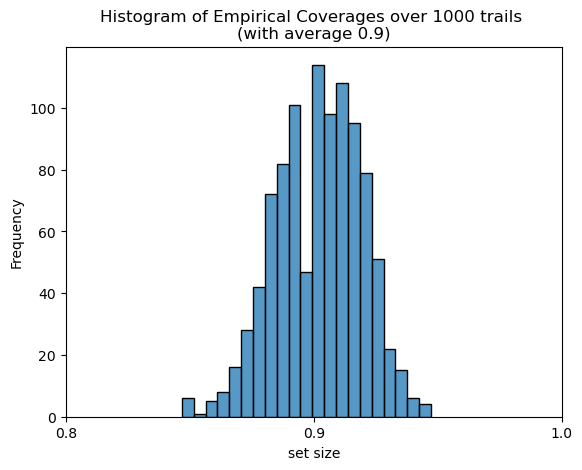

In [2]:
from CP import CP
nm = "FixCaps"
## APS
### correctness check
cp = CP(nm, smx=smx, labels=labels, n_cali=1112, R=1000)
scores = cp.get_APS_score(smx, labels)
cp.cc(scores)

The empirical coverage is: 0.8567839195979899


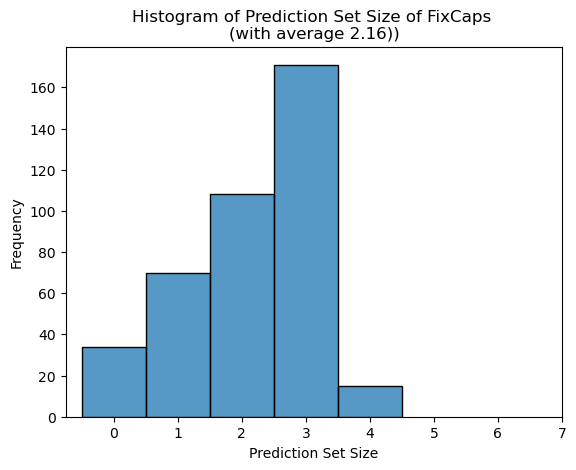

The feature-stratified coverage array is:
 [1.         0.76       0.95081967 0.23076923 0.95121951 0.85477178
 0.88888889]
The size-stratified coverage array is:
 [0.91428571 0.9537037  0.93548387]


In [3]:
ps = cp.get_APS()
empirical_coverage = cp.get_sample_coverage()
cp.hist_SPS()
fsc = cp.get_fsc()
ssc = cp.get_ssc()

In [4]:
ec_list = []
sps_avg_list = []
fsc_list = []
ssc_list = []
for i in range(20):
    cp = CP(nm, smx=smx, labels=labels, n_cali=1112)
    ps = cp.get_APS()
    ec_list.append(cp.get_sample_coverage(pt=False))
    sps_avg_list.append(cp.hist_SPS(plot=False))
    fsc_list.append(cp.get_fsc(array=False))
    ssc_list.append(cp.get_ssc(array=False))
print(f"the empirical coverage for each data split is:\n {ec_list}")
print(f"the average size of prediction sets for each data split is:\n {sps_avg_list}")
print(f"the fsc metric for each data split is:\n {fsc_list}")
print(f"the ssc metric for each data split is:\n {ssc_list}")

the empirical coverage for each data split is:
 [0.8793969849246231, 0.914572864321608, 0.9120603015075377, 0.9321608040201005, 0.8542713567839196, 0.9221105527638191, 0.864321608040201, 0.8969849246231156, 0.9246231155778895, 0.9321608040201005, 0.9271356783919598, 0.9120603015075377, 0.9170854271356784, 0.9221105527638191, 0.9095477386934674, 0.8894472361809045, 0.9020100502512562, 0.9120603015075377, 0.8793969849246231, 0.9045226130653267]
the average size of prediction sets for each data split is:
 [2.23, 2.31, 2.19, 2.28, 2.12, 2.29, 2.18, 2.23, 2.25, 2.31, 2.32, 2.28, 2.23, 2.3, 2.36, 2.21, 2.24, 2.31, 2.15, 2.27]
the fsc metric for each data split is:
 [0.375, 0.4, 0.4375, 0.5555555555555556, 0.4, 0.375, 0.3333333333333333, 0.47058823529411764, 0.5833333333333334, 0.3, 0.6363636363636364, 0.3333333333333333, 0.36363636363636365, 0.35714285714285715, 0.3333333333333333, 0.4117647058823529, 0.5625, 0.2727272727272727, 0.09090909090909091, 0.6666666666666666]
the ssc metric for eac

The empirical coverage is: 0.8814432989690721


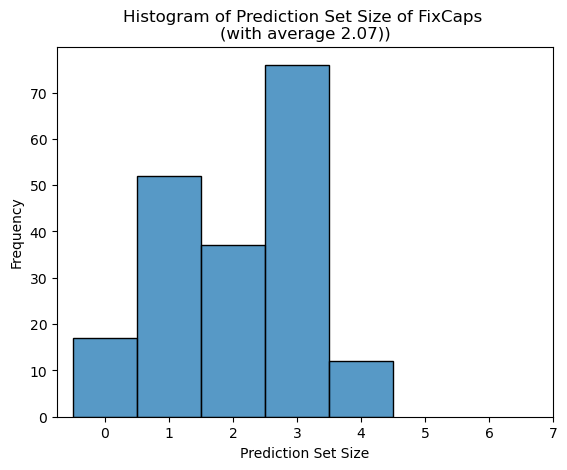

The feature-stratified coverage array is:
 [1.         1.         0.86363636 0.         1.         0.875
 0.66666667]
The size-stratified coverage array is:
 [0.96153846 0.97297297 0.96590909]


In [5]:
## Conformal prediction with calibration data as the test dataset and validation data as the small validation dataset (did not use for training)
cp = CP(nm, cal_smx=smx, cal_labels=labels, val_smx=smx_val, val_labels=labels_val)
ps = cp.get_APS()
empirical_coverage = cp.get_sample_coverage()
cp.hist_SPS()
fsc = cp.get_fsc()
ssc = cp.get_ssc()

In [6]:
## RAPS
### CV for hyper parameters lam_reg and k_reg
cp = CP(nm, sc=1, smx=smx, labels=labels, n_cali=1112)
cp.cv_hypas()

Optimal parameters: lam_reg=0.05, k_reg=0
Coverage: 0.9298262548262549, Average set size: 1.74646879021879


In [23]:
lam_reg=0.05
k_reg=0

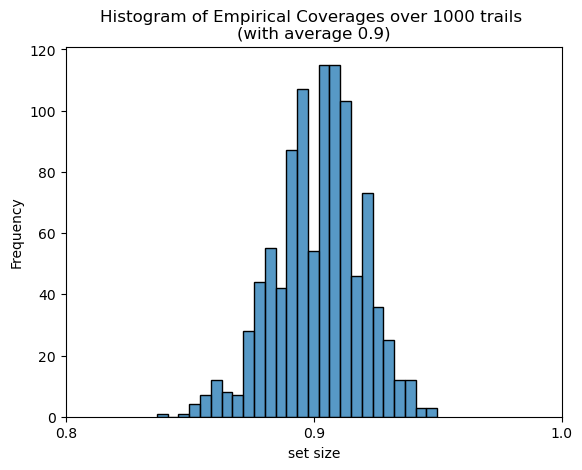

In [24]:
## correctness check
cp = CP(nm, sc=1, smx=smx, labels=labels, n_cali=1112, R=1000, lam_reg=lam_reg, k_reg=k_reg)
scores = cp.get_RAPS_score(heu_score=smx, lbs=labels)
cp.cc(scores)

The empirical coverage is: 0.907035175879397


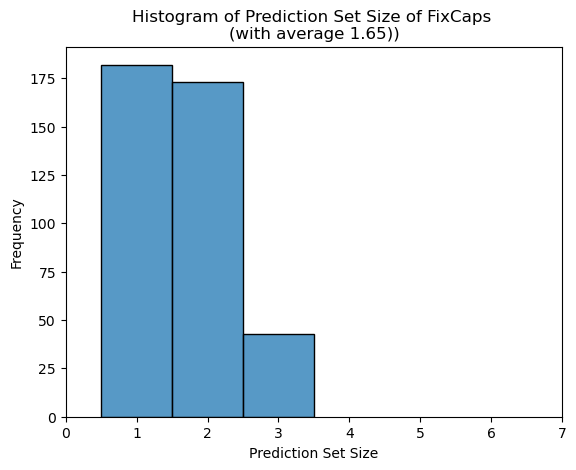

The feature-stratified coverage array is:
 [0.8        0.72413793 0.87037037 0.38461538 0.91111111 0.98717949
 0.61538462]
The size-stratified coverage array is:
 [0.94505495 0.89017341 0.81395349]


In [25]:
ps = cp.get_RAPS()
empirical_coverage = cp.get_sample_coverage()
cp.hist_SPS()
fsc = cp.get_fsc()
ssc = cp.get_ssc()

In [26]:
ec_list = []
sps_avg_list = []
fsc_list = []
ssc_list = []
for i in range(20):
    cp = CP(nm, sc=1, smx=smx, labels=labels, n_cali=1112, k_reg=k_reg, lam_reg=lam_reg)
    ps = cp.get_RAPS()
    ec_list.append(cp.get_sample_coverage(pt=False))
    sps_avg_list.append(cp.hist_SPS(plot=False))
    fsc_list.append(cp.get_fsc(array=False))
    ssc_list.append(cp.get_ssc(array=False))
print(f"the empirical coverage for each data split is:\n {ec_list}")
print(f"the average size of prediction sets for each data split is:\n {sps_avg_list}")
print(f"the fsc metric for each data split is:\n {fsc_list}")
print(f"the ssc metric for each data split is:\n {ssc_list}")

the empirical coverage for each data split is:
 [0.9195979899497487, 0.9447236180904522, 0.914572864321608, 0.9095477386934674, 0.9447236180904522, 0.9221105527638191, 0.9195979899497487, 0.8994974874371859, 0.9095477386934674, 0.9120603015075377, 0.8944723618090452, 0.9447236180904522, 0.9296482412060302, 0.9271356783919598, 0.9095477386934674, 0.8944723618090452, 0.9095477386934674, 0.9120603015075377, 0.9296482412060302, 0.9296482412060302]
the average size of prediction sets for each data split is:
 [1.8, 1.76, 1.67, 1.69, 1.81, 1.77, 1.74, 1.66, 1.72, 1.68, 1.73, 1.8, 1.71, 1.7, 1.65, 1.62, 1.71, 1.67, 1.77, 1.73]
the fsc metric for each data split is:
 [0.16666666666666666, 0.5, 0.2, 0.23076923076923078, 0.2857142857142857, 0.18181818181818182, 0.4375, 0.2, 0.46153846153846156, 0.13333333333333333, 0.25, 0.4444444444444444, 0.2, 0.125, 0.3, 0.3125, 0.26666666666666666, 0.1111111111111111, 0.4166666666666667, 0.3333333333333333]
the ssc metric for each data split is:
 [0.896373056

The empirical coverage is: 0.9278350515463918


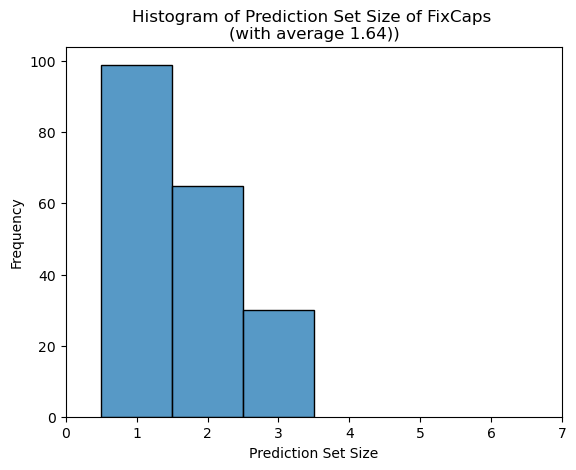

The feature-stratified coverage array is:
 [0.875      1.         0.81818182 0.         1.         0.96527778
 0.        ]
The size-stratified coverage array is:
 [0.96969697 0.89230769 0.86666667]


In [27]:
## Conformal prediction with calibration data as the test dataset and validation data as the small validation dataset (did not use for training)
cp = CP(nm, sc=1, cal_smx=smx, cal_labels=labels, val_smx=smx_val, val_labels=labels_val, k_reg=k_reg, lam_reg=lam_reg)
ps = cp.get_RAPS()
empirical_coverage = cp.get_sample_coverage()
cp.hist_SPS()
fsc = cp.get_fsc()
ssc = cp.get_ssc()